# Base

In [1]:
import os
from google.colab import drive
from google.colab import files
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from numpy import genfromtxt
import seaborn as sns
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install torchinfo
from torchinfo import summary

In [3]:
!mkdir data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t0_control.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t0_experimental.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t1_control.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t1_experimental.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t2_control.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t2_experimental.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t3_control.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t3_experimental.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t4_control.txt.json /content/data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/data_ext_t4_experimental.txt.json /content/data
os.chdir("/content/data")

In [4]:
manualSeed=1
dataroot = "/content/data/Data_exp/"
num_workers = 2
batch_size = 32
num_epochs = 1500
lr = 0.0001
beta1 = 0.5
ngpu = 1
nb_n=32
torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
g = torch.Generator()
g.manual_seed(manualSeed)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
l= os.listdir("/content/data")

In [5]:
name_list=['data_ext_t2_experimental.txt.json', 'data_ext_t4_control.txt.json',
 'data_ext_t0_experimental.txt.json', 'data_ext_t1_control.txt.json',
 'data_ext_t1_experimental.txt.json', 'data_ext_t0_control.txt.json',
 'data_ext_t3_control.txt.json', 'data_ext_t2_control.txt.json',
 'data_ext_t4_experimental.txt.json', 'data_ext_t3_experimental.txt.json']

In [ ]:
name_list[0][12:-9]

'experimental'

In [ ]:
f=open('data_ext_t2_experimental.txt.json')
L=json.load(f)

In [ ]:
len(L[0])

41

In [6]:
ds_list=[]
t=11
L_val=[]
L_train=[]
ind=0
for name in name_list:
  f=open(name)
  group=name[12:-9]
  num=name[10:11]
  L = json.load(f)
  if group=="control":
    label=0
    for k in range(0,len(L)):
      for i in range(0,len(L[k]),2):
        L_train.append([L[k][i],label])
  if group=="experimental":
    if int(num)>=2:
      label=1
      ind+=1
    else:
      label=0
    for k in range(0,len(L)):
      if k==t:
        for i in range(0,len(L[k])):
          L_val.append([L[k][i],label])
      else :
        if label==0:
          for i in range(0,len(L[k]),2):
            L_train.append([L[k][i],label])
        if label==1:
          for i in range(0,len(L[k])):
            L_train.append([L[k][i],label])
ds_list.append([L_train,L_val])

#fct

In [7]:
def conf_mat(datal,trsh):
  x=datal[0].float().to(device)
  y=net(x).view(-1)
  pred=(y>trsh).int()
  label=datal[1].float().to(device).view(-1).int()
  #num=datal[2].float().to(device).int()
  comp=torch.eq(label,pred).int()
  mat_label=np.zeros((3,4))
  mat_nolbl=np.zeros((2,2))
  for i in range(0,2):
    tens=torch.where(label==i,1,0)
    numtot=torch.sum(tens).item()
    num_G=torch.sum(torch.where(torch.mul(tens,comp)==1,1,0)).item()
    if i ==1:
      mat_nolbl[0,0]+=num_G
      mat_nolbl[1,0]+=numtot-num_G
    else:
      mat_nolbl[1,1]+=num_G
      mat_nolbl[0,1]+=numtot-num_G
  return mat_nolbl

In [ ]:
len(ds_list[0][0][1])

2

In [ ]:
ds_list[0][0][0][1]

1

#DS creation kfold

In [8]:
class ds_pd(Dataset):
    def __init__(self, list_sample):
        self.samples = []
        for i in range(0,len(list_sample)):
            label=list_sample[i][1]
            x=np.array(list_sample[i][0])
            self.samples.append((x,label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [9]:
len(ds_list)

1

In [10]:
fold_list=[]
for ds in ds_list:
  ds_t=ds_pd(ds[0])
  ds_v=ds_pd(ds[1])
  fold_list.append([ds_t,ds_v])

In [11]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
dataloader_t = torch.utils.data.DataLoader(fold_list[0][0],batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)

In [ ]:
len(next(iter(dataloader_t))[0][0])

63

#Model

In [12]:
from torch.nn.modules.activation import LeakyReLU

def init_weights(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
class ClassifierECG(nn.Module):
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(63,256,bias=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(256,64,bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64,32,bias=True),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(32,8,bias=True),
            nn.BatchNorm1d(8),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(8,1,bias=True),
            nn.Sigmoid()
        )
        self.nnECG.apply(init_weights)

    def forward(self, input):
        return self.nnECG(input)


''

#Training

In [20]:
net= ClassifierECG(ngpu).to("cuda")

In [21]:
summary(net)

Layer (type:depth-idx)                   Param #
ClassifierECG                            --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       16,384
│    └─BatchNorm1d: 2-2                  512
│    └─Dropout: 2-3                      --
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       16,448
│    └─BatchNorm1d: 2-6                  128
│    └─Dropout: 2-7                      --
│    └─LeakyReLU: 2-8                    --
│    └─Linear: 2-9                       2,080
│    └─BatchNorm1d: 2-10                 64
│    └─Dropout: 2-11                     --
│    └─LeakyReLU: 2-12                   --
│    └─Linear: 2-13                      264
│    └─BatchNorm1d: 2-14                 16
│    └─Dropout: 2-15                     --
│    └─LeakyReLU: 2-16                   --
│    └─Linear: 2-17                      9
│    └─Sigmoid: 2-18                     --
Total params: 35,905
Trainable params: 35,905
Non-trainabl

In [ ]:
lr=0.0001
beta1=0.9
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
def training(net,dataloader_t,dataloader_v,num_epochs):
  Loss = []
  Lossv= []
  for epoch in range(num_epochs):
      if epoch%10==0:
        print(epoch)
      L_t=[]
      L_v=[]
      for i, dataj in enumerate(dataloader_t, 0):
          net.zero_grad()
          x=dataj[0].float().to(device)
          yhat=dataj[1].float().to(device)
          yhat=yhat.view(-1,1)
          y=net(x)
          err_t=nn.BCELoss()(y.float(),yhat.float())
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
      for i, dataj in enumerate(dataloader_v, 0):
        net.eval()     
        x=dataj[0].float().to(device)
        yhat=dataj[1].float().to(device)
        yhat=yhat.view(-1,1)
        y=net(x)
        err_v=nn.BCELoss()(y.float(),yhat.float())
        L_v.append(err_v.item())
      err=np.mean(L_t)
      errv=np.mean(L_v)
      Loss.append(err)
      Lossv.append(errv)
      torch.save(net.state_dict(), "net/epoch_"+str(epoch)+".pth")
  return [Lossv,np.argmin(Lossv)]

In [ ]:
!rm -r net

In [15]:
!rm -r net
!mkdir net
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
L=[]    
cntr=0
for j in range(0,len(fold_list)):
  ds=fold_list[j]
  net= ClassifierECG(ngpu).to(device)
  lr=0.0005
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  dataset_t=ds[0]
  dataset_v=ds[1]
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  L.append(training(net,dataloader_t,dataloader_v,100))
  cntr+=1
  print(cntr)

rm: cannot remove 'net': No such file or directory
0
10
20
30
40
50
60
70
80
90
1


In [ ]:
L[0][0]

[1.1502834558486938,
 1.2663649320602417,
 1.6180621981620789,
 1.806532859802246,
 1.5579835772514343,
 1.4181027015050252,
 1.3842010696729024,
 1.6147295435269673,
 1.6824063062667847,
 1.4792130589485168]

In [ ]:
f = open ("results.txt", "w")
for i in range (0,len (L)) :                
    f.write ( str (L[i][0]) + "\t" + str(L[i][1]))    
    f.write ("\n")                           
f.close ()   

In [ ]:
!cp -r /content/data/net /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/
!cp /content/data/results.txt /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/

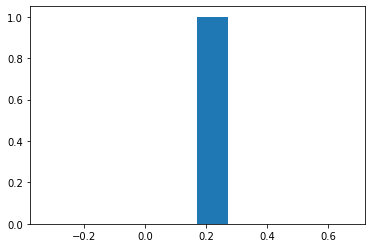

In [16]:
minloss=[min(x[0])for x in L]
plt.hist(minloss)
plt.show()

In [17]:
n=int(np.argmin([min(x[0])for x in L]))
dataset_t=fold_list[0][0]
dataset_v=fold_list[0][1]
epch=np.argmin(L[int(n)][0])
net= ClassifierECG(ngpu).to(device)
lr=0.0001
beta1=0.9
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
net.load_state_dict(torch.load("net/epoch_"+str(epch)+".pth"))
dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=False)

In [ ]:
#!cp /content/data/net/net_11_1_epoch_10.pth /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Testing/

accuracy 1.0
precision 1.0
recall 1.0
F1score 1.0


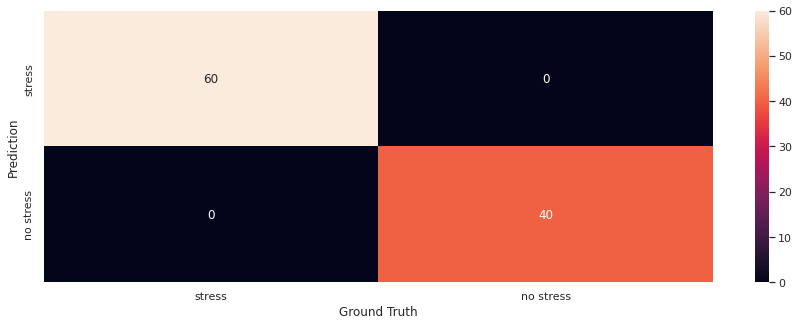

In [19]:
# Results
import seaborn as sns

Loss = []
trsh=0.5
net.eval()
confusion=np.zeros((2,2))
for i, datal in enumerate(dataloader_v, 0):
      confusiont=conf_mat(datal,trsh)
      confusion+=confusiont
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['total','stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']

# create seabvorn heatmap with required labels
#
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=1)
sns.heatmap((100*confusion/len(dataset_v)).astype('int32'), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=True,ax=axs)
axs.set_xlabel('Ground Truth')
axs.set_ylabel('Prediction')
TP=confusion[0,0]
TN=confusion[1,1]
FN=confusion[1,0]
FP=confusion[0,1]
acc=(TP+TN)/(TP+FP+FN+TN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
F1score=(2*recall*precision)/(recall+precision)
print("accuracy " +str(acc))
print("precision " +str(precision))
print("recall " +str(recall))
print("F1score "+str(F1score))

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
accuracy 0.9140625
precision 0.8403361344537815
recall 0.8771929824561403
F1score 0.8583690987124464


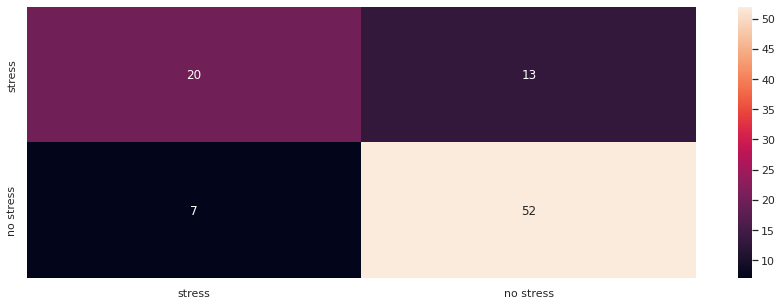

In [ ]:
confusionmean=np.zeros((2,2))
acc_list=[]
prec_list=[]
recall_list=[]
f1_list=[]
for n in range(0,len(fold_list)):
  if n%5==0:
    print(n)
  k=fold_list[n][2]
  j=fold_list[n][3]
  dataset_t=fold_list[n][0]
  dataset_v=fold_list[n][1]
  epch=np.argmin(L[int(n)][0])
  net= ClassifierECG(ngpu).to(device)
  lr=0.0001
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  net.load_state_dict(torch.load("net/net_"+str(j)+"_"+str(k)+"_epoch_"+str(epch)+".pth"))
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  trsh=0.4
  net.eval()
  confusion=np.zeros((2,2))
  for i, datal in enumerate(dataloader_v, 0):
        confusiont=conf_mat(datal,trsh)
        confusion+=confusiont  
  TP=confusion[0,0]
  TN=confusion[1,1]
  FN=confusion[1,0]
  FP=confusion[0,1]
  acc=(TP+TN)/(TP+FP+FN+TN)
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1score=(2*recall*precision)/(recall+precision)
  if recall+precision ==0:
    F1score=0
  acc_list.append(acc)
  prec_list.append(precision)
  recall_list.append(recall)
  f1_list.append(F1score)
  confusionmean+=(100*confusion/len(dataset_v))


confusionmean/=len(L)
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['total','stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=1)
sns.heatmap(confusionmean.astype('int32'), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=True,ax=axs)

print("accuracy " +str(acc))
print("precision " +str(precision))
print("recall " +str(recall))
print("F1score "+str(F1score))

In [ ]:
len(L)

91

In [ ]:
confusionmean=np.zeros((2,2))
acc_list=[]
prec_list=[]
recall_list=[]
f1_list=[]
n=165
print(n)
k=fold_list[n][2]
j=fold_list[n][3]
dataset_t=fold_list[n][0]
dataset_v=fold_list[n][1]
epch=np.argmin(L[int(n/5)][0])
net= ClassifierECG(ngpu).to(device)
lr=0.0001
beta1=0.9
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
net.load_state_dict(torch.load("net/net_"+str(j)+"_"+str(k)+"_epoch_"+str(epch)+".pth"))
dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
trsh=0.5
net.eval()
confusion=np.zeros((2,2))
for i, datal in enumerate(dataloader_v, 0):
      confusiont=conf_mat(datal,trsh)
      confusion+=confusiont  
TP=confusion[0,0]
TN=confusion[1,1]
FN=confusion[1,0]
FP=confusion[0,1]
acc=(TP+TN)/(TP+FP+FN+TN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
F1score=(2*recall*precision)/(recall+precision)


165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
print(confusion)

[[  0.  19.]
 [210. 475.]]


In [ ]:
F1score

0.7549909255898367

Text(0.3, 23, 'std: 0.145')

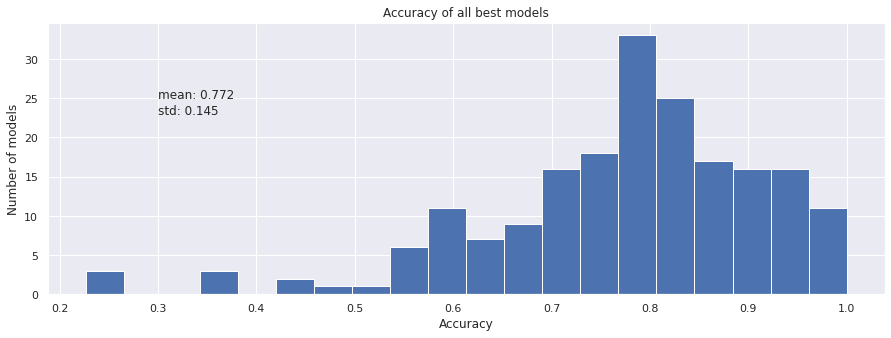

In [ ]:
mes=acc_list
plt.hist(mes,bins=20)
plt.title('Accuracy of all best models')
plt.xlabel('Accuracy') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.3, 25, txtm)
plt.text(0.3, 23, txtstd)

Text(0.1, 16, 'std: 0.197')

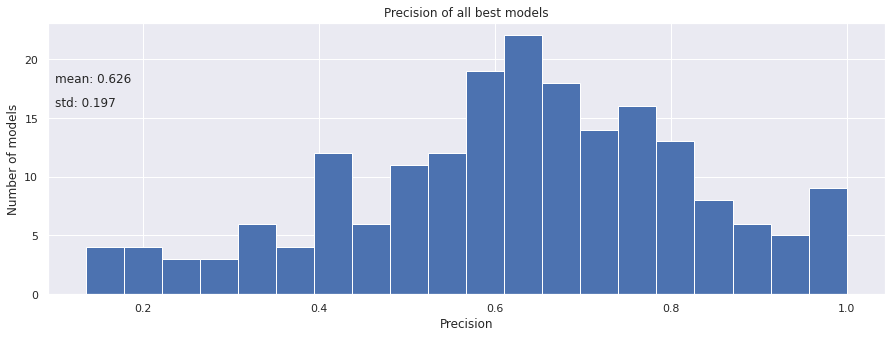

In [ ]:
mes=prec_list
plt.hist(mes,bins=20)
plt.title('Precision of all best models')
plt.xlabel('Precision') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.1, 18, txtm)
plt.text(0.1, 16, txtstd)

Text(0.1, 18, 'std: 0.242')

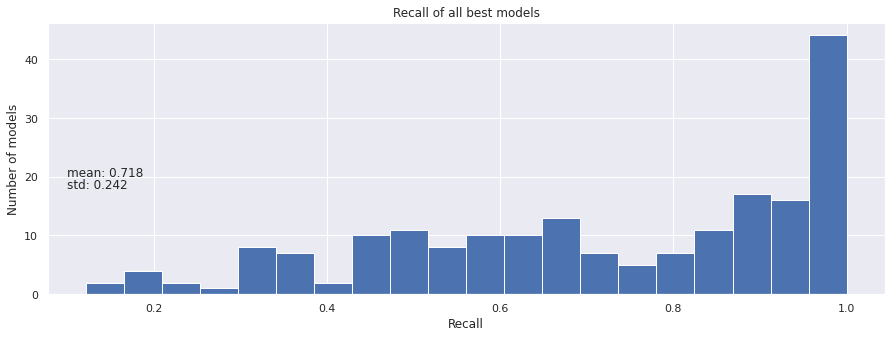

In [ ]:
mes=recall_list
plt.hist(mes,bins=20)
plt.title('Recall of all best models')
plt.xlabel('Recall') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.1, 20, txtm)
plt.text(0.1, 18, txtstd)

Text(0.2, 14, 'std: 0.202')

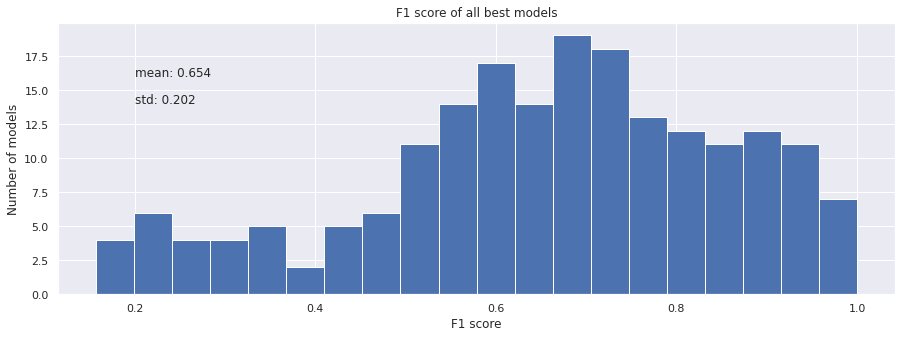

In [ ]:
mes=f1_list
plt.hist(mes,bins=20)
plt.title('F1 score of all best models')
plt.xlabel('F1 score') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.2, 16, txtm)
plt.text(0.2, 14, txtstd)

In [ ]:
f1_list[33]

nan

In [ ]:
33*5

165

In [ ]:
f1_list

[0.43548387096774194,
 0.3409395973154362,
 0.4549549549549549,
 0.3881578947368421,
 0.17624521072796936,
 0.41159420289855075,
 0.3117505995203837,
 0.24686192468619245,
 0.742063492063492,
 0.6406779661016949,
 0.6762075134168156,
 0.13013698630136988,
 0.40479360852197066,
 0.007042253521126761,
 0.10584958217270196,
 0.16494845360824742,
 0.5378973105134475,
 0.7070312500000001,
 0.6619385342789599,
 0.5722713864306784,
 0.5353846153846153,
 0.7272727272727273,
 0.6141479099678457,
 0.6860254083484573,
 0.4480746791131855,
 0.4076923076923077,
 0.4371584699453552,
 0.3493449781659389,
 0.3915094339622642,
 0.62,
 0.720173535791757,
 0.7463917525773196,
 0.6645367412140575,
 nan,
 0.7589928057553957,
 0.6347305389221557,
 0.5974395448079659,
 0.4114002478314746,
 0.5726744186046512]

#Reload list

In [ ]:
net= ClassifierECG(ngpu).to("cuda")

In [ ]:
lr=0.0001
beta1=0.9
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
!cp -r /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/net /content/data/
!cp /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Pd_DS2/results.txt /content/data/

In [ ]:

f = open("results.txt", "r")
L=[]
for i in range (0,195) :
  a=[]
  strr=f.readline()          
  a.append(list(map(float,strr.split("\t")[0][1:-1].split(","))))
  a.append(int(strr.split("\t")[1][0:-1]))
  L.append(a)                             
f.close ()   

In [ ]:
minloss=[np.min(x[0]) for x in L]

(array([19., 17.,  6.,  9., 13.,  8.,  9.,  1.,  5.,  4.]),
 array([0.01110447, 0.06443399, 0.11776351, 0.17109303, 0.22442255,
        0.27775207, 0.33108159, 0.38441111, 0.43774063, 0.49107015,
        0.54439967]),
 <a list of 10 Patch objects>)

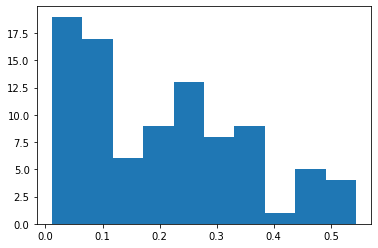

In [ ]:
plt.hist(minloss)

In [ ]:
#!cp -r /content/data/net /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Dataset/
#!cp /content/data/results.txt /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Dataset/

In [ ]:
listsave=L

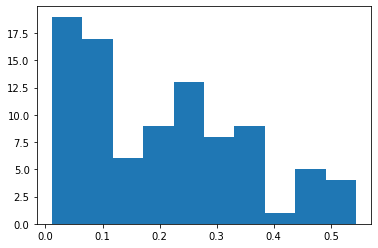

In [ ]:
minloss=[min(x[0])for x in L]
plt.hist(minloss)
plt.show()

In [ ]:
n=np.argmin([min(x[0])for x in L])
k=list_ds[n][2]
j=list_ds[n][3]
epch=np.argmin(L[n][0])
net= ClassifierECG(ngpu).to(device)
lr=0.0001
beta1=0.9
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
net.load_state_dict(torch.load("net/net_"+str(j)+"_"+str(k)+"_epoch_"+str(epch)+".pth"))
dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)

In [ ]:
#!cp /content/data/net/net_11_1_epoch_10.pth /content/gdrive/MyDrive/Colab\ Notebooks/Research\ Project/Testing/

accuracy 0.8982954545454546
precision 0.7433501078360891
recall 0.8517298187808896
F1score 0.7938579654510556


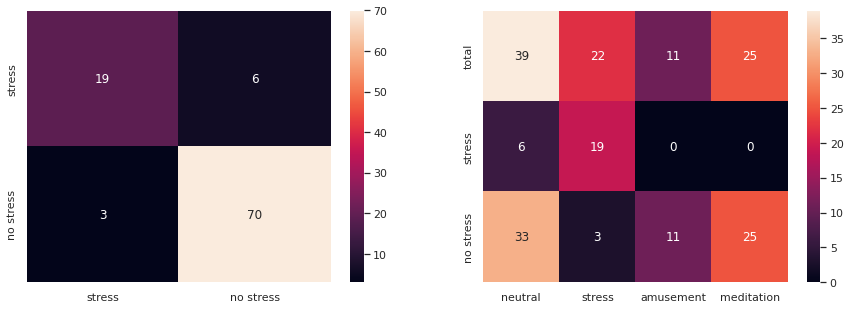

In [ ]:
# Results
import seaborn as sns

Loss = []
trsh=0.5
net.eval()
confusionlabel=np.zeros((3,4))
confusion=np.zeros((2,2))
for i, datal in enumerate(dataloader_v, 0):
      confusionlabelt,confusiont=conf_mat(datal,trsh)
      confusion+=confusiont
      confusionlabel+=confusionlabelt
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['total','stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']

# create seabvorn heatmap with required labels
#
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=2)
sns.heatmap((100*confusion/len(dataset_v)).astype('int32'), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=True,ax=axs[0])
sns.heatmap((100*confusionlabel/len(dataset_v)).astype('int32'), xticklabels=x_axis_confl, yticklabels=y_axis_confl, annot=True,ax=axs[1])
TP=confusion[0,0]
TN=confusion[1,1]
FN=confusion[1,0]
FP=confusion[0,1]
acc=(TP+TN)/(TP+FP+FN+TN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
F1score=(2*recall*precision)/(recall+precision)
print("accuracy " +str(acc))
print("precision " +str(precision))
print("recall " +str(recall))
print("F1score "+str(F1score))

In [ ]:
confusionlabelmean=np.zeros((3,4))
confusionmean=np.zeros((2,2))
acc_list=[]
prec_list=[]
recall_list=[]
f1_list=[]
for n in range(0,len(L)):
  if n%10==0:
    print(n)
  k=list_ds[n][2]
  j=list_ds[n][3]
  dataset_t=list_ds[n][0]
  dataset_v=list_ds[n][1]
  epch=np.argmin(L[n][0])
  net= ClassifierECG(ngpu).to(device)
  lr=0.0001
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  net.load_state_dict(torch.load("net/net_"+str(j)+"_"+str(k)+"_epoch_"+str(epch)+".pth"))
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  trsh=0.5
  net.eval()
  confusionlabel=np.zeros((3,4))
  confusion=np.zeros((2,2))
  for i, datal in enumerate(dataloader_v, 0):
        confusionlabelt,confusiont=conf_mat(datal,trsh)
        confusion+=confusiont
        confusionlabel+=confusionlabelt  
  TP=confusion[0,0]
  TN=confusion[1,1]
  FN=confusion[1,0]
  FP=confusion[0,1]
  acc=(TP+TN)/(TP+FP+FN+TN)
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1score=(2*recall*precision)/(recall+precision)
  acc_list.append(acc)
  prec_list.append(precision)
  recall_list.append(recall)
  f1_list.append(F1score)
  confusionlabelmean+=(100*confusionlabel/len(dataset_v))
  confusionmean+=(100*confusion/len(dataset_v))


confusionmean/=len(L)
confusionlabelmean/=len(L)
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['total','stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=2)
sns.heatmap(confusionmean.astype('int32'), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=True,ax=axs[0])
sns.heatmap(confusionlabelmean.astype('int32'), xticklabels=x_axis_confl, yticklabels=y_axis_confl, annot=True,ax=axs[1])

#print("accuracy " +str(acc))
#print("precision " +str(precision))
#print("recall " +str(recall))
#print("F1score "+str(F1score))

0


NameError: ignored

Text(0.3, 5, 'std: 0.142')

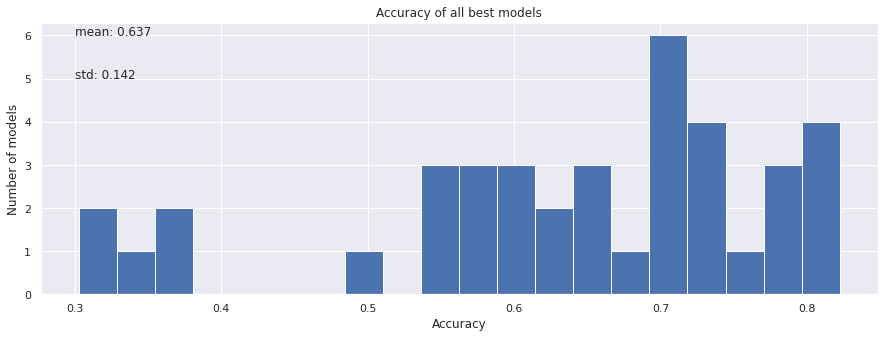

In [ ]:
mes=acc_list
plt.hist(mes,bins=20)
plt.title('Accuracy of all best models')
plt.xlabel('Accuracy') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.3, 6, txtm)
plt.text(0.3, 5, txtstd)

Text(0.35, 12, 'std: 0.173')

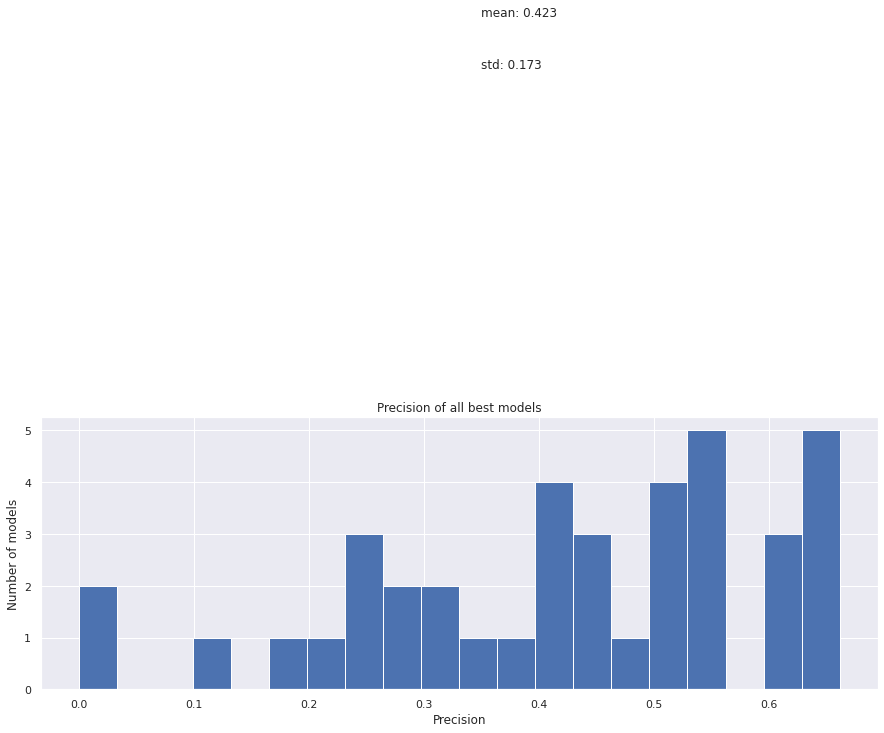

In [ ]:
mes=prec_list
plt.hist(mes,bins=20)
plt.title('Precision of all best models')
plt.xlabel('Precision') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.35, 13, txtm)
plt.text(0.35, 12, txtstd)

Text(0.05, 40, 'std: 0.198')

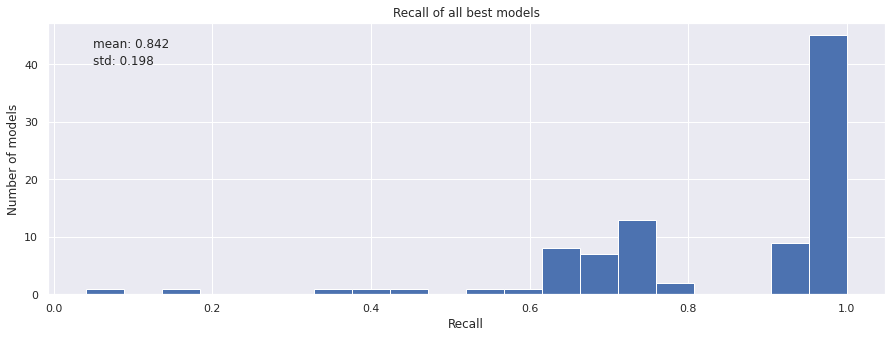

In [ ]:
mes=recall_list
plt.hist(mes,bins=20)
plt.title('Recall of all best models')
plt.xlabel('Recall') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.05, 43, txtm)
plt.text(0.05, 40, txtstd)

Text(0.05, 16, 'std: 0.165')

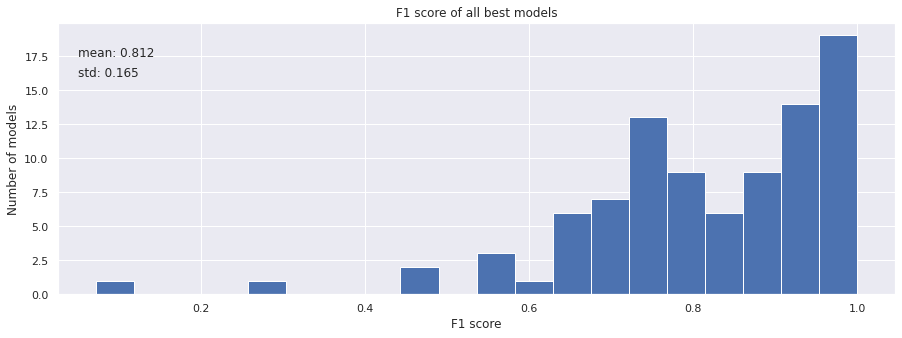

In [ ]:
mes=f1_list
plt.hist(mes,bins=20)
plt.title('F1 score of all best models')
plt.xlabel('F1 score') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.05, 17.5, txtm)
plt.text(0.05, 16, txtstd)